In [1]:
import glob 
import numpy as np 
import matplotlib.pyplot as plt 

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img 

%matplotlib inline

### De cel hieronder is de functie om de gezichten uit de fotos te knippen.

In [2]:
import glob 
import cv2
import sys
import uuid

def image_get_faces(image_name, location):
    image = cv2.imread(image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(100, 100)
    )

    for (x, y, w, h) in faces:
        print("[INFO] Found {0} Faces.".format(len(faces)), end=' ')
        print((x, y, w, h), end=' ') 
        print("Object found, saved.")
        tempname = str(uuid.uuid4().hex)
        clip = cv2.resize(image[y:y + h, x:x + w],(150,150))
        cv2.imwrite(str(location) + tempname + '_faces.jpg', clip)

In [3]:
PATH_TO_PICTURES = 'C:\\fotos\\*.jpg' 

# example 'Z:\\Media\\Fotos\\2016-2018\\*.jpg'

# let-op de faces-scrape folder bevat de ruwe images.
# Copy de uiteindelijke imeges naar de faces2 folder en de 
# test images naar faces-test folder

train_files = glob.glob(PATH_TO_PICTURES)            
for img in train_files:
    image_get_faces(img,'faces-scrape\\')

[INFO] Found 1 Faces. (146, 4, 212, 212) Object found, saved.
[INFO] Found 1 Faces. (244, 209, 556, 556) Object found, saved.
[INFO] Found 1 Faces. (280, 201, 401, 401) Object found, saved.
[INFO] Found 1 Faces. (66, 68, 229, 229) Object found, saved.
[INFO] Found 1 Faces. (109, 110, 230, 230) Object found, saved.
[INFO] Found 1 Faces. (189, 158, 566, 566) Object found, saved.
[INFO] Found 1 Faces. (168, 75, 134, 134) Object found, saved.
[INFO] Found 1 Faces. (319, 319, 125, 125) Object found, saved.
[INFO] Found 1 Faces. (475, 154, 349, 349) Object found, saved.
[INFO] Found 1 Faces. (461, 51, 143, 143) Object found, saved.
[INFO] Found 1 Faces. (520, 140, 337, 337) Object found, saved.
[INFO] Found 1 Faces. (93, 124, 401, 401) Object found, saved.
[INFO] Found 1 Faces. (427, 220, 148, 148) Object found, saved.
[INFO] Found 1 Faces. (27, 49, 133, 133) Object found, saved.
[INFO] Found 1 Faces. (363, 112, 358, 358) Object found, saved.
[INFO] Found 1 Faces. (277, 44, 184, 184) Object 

In [4]:
IMG_DIM = (150, 150)

# De labels worden uit het aantal verschillende filenamen gehaald.(de nummers en haakjes worden gewist)

train_files = glob.glob('faces2\\*.jpg')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].rstrip(' (12345678900)') for fn in train_files]

unknown_files = glob.glob('faces-test\\*.jpg')
unknown_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in unknown_files]
unknown_imgs = np.array(unknown_imgs)
unknown_labels = [fn.split('\\')[1].split('.')[0].rstrip(' (12345678900)') for fn in unknown_files]


### Hieronder begint de data augmentation het genereren van extra images.

In [5]:
train_datagen =  ImageDataGenerator(rescale=1./255, zoom_range=0.2, rotation_range=20,
                                    width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, 
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

unknown_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_labels

['eminem',
 'eminem',
 'eminem',
 'eminem',
 'eminem',
 'eminem',
 'eminem',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'frank',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'geert',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark',
 'mark']

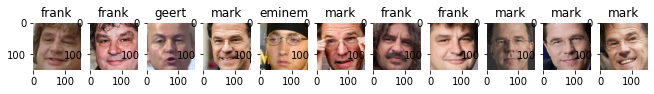

In [7]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
transformed_label = encoder.fit_transform(train_labels)
unknown_transformed_label = encoder.transform(unknown_labels)

train_generator = train_datagen.flow(train_imgs, transformed_label, batch_size=128)
val_generator = val_datagen.flow(train_imgs, transformed_label,batch_size=64)
unknown_generator = val_datagen.flow(unknown_imgs, unknown_transformed_label,batch_size=64)

# letop als je een ander aantal personen hebt moet je dit aanpassen.
def test_generator(generator, nr = 10 ):
    names = ['eminem' , 'frank'  , 'geert', 'mark']
    fig, ax = plt.subplots(1,nr, figsize=(nr, 20), frameon=False)
    vals, labs = next(generator)
    for i in range(0,nr):
        ax[i].imshow(vals[i])
        ax[i].set_frame_on(False)
        ax[i].set_title(names[np.argmax(labs[i])])
        
test_generator(unknown_generator, nr=11)


In [8]:
from keras.applications import vgg16
from keras.models import Model
import keras
import pandas as pd

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = True
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

vgg_model.summary() 

# Print layer status.
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000018CFE61DE50>,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0x0000018D0082A6D0>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x0000018D008CC280>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x0000018D0082AE80>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x0000018D009196D0>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x0000018D00920490>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x0000018D0090C700>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x0000018D00924A90>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x0000018D0092E790>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x0000018D00931AC0>,block3_conv3,True


In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, GRU, Dropout
from keras import optimizers
import shutil as sh
import tensorflow as tf

tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=0, write_graph=True, write_images=True)
sh.rmtree('logs',ignore_errors=True)
callbacks = [tbCallBack]

model = Sequential()
model.add(vgg_model) # Stop het complete vgg model in het nieuwe model.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8192)              14714688  
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 15,780,420
Trainable params: 15,780,420
Non-trainable params: 0
__________________________________________

In [30]:
callbacks = [tbCallBack]

sh.rmtree('logs',ignore_errors=True)
history = model.fit(train_generator, steps_per_epoch=1, epochs=10,
                              validation_data=unknown_generator, validation_steps=50,
                              verbose=1,callbacks=callbacks)


Epoch 1/10
1/1 [==============================] - 14s 14s/step - loss: 0.7273 - accuracy: 0.1406 - val_loss: 0.8346 - val_accuracy: 0.0909
Epoch 2/10
1/1 [==============================] - 12s 12s/step - loss: 0.8906 - accuracy: 0.2031
Epoch 3/10
1/1 [==============================] - 13s 13s/step - loss: 0.6727 - accuracy: 0.2812
Epoch 4/10
1/1 [==============================] - 12s 12s/step - loss: 0.6752 - accuracy: 0.2812
Epoch 5/10
1/1 [==============================] - 12s 12s/step - loss: 0.6728 - accuracy: 0.2656
Epoch 6/10
1/1 [==============================] - 12s 12s/step - loss: 0.6457 - accuracy: 0.2969
Epoch 7/10
1/1 [==============================] - 12s 12s/step - loss: 0.6341 - accuracy: 0.2500
Epoch 8/10
1/1 [==============================] - 12s 12s/step - loss: 0.5865 - accuracy: 0.3438
Epoch 9/10
1/1 [==============================] - 12s 12s/step - loss: 0.5493 - accuracy: 0.3750
Epoch 10/10
1/1 [==============================] - 12s 12s/step - loss: 0.5258 - accu

In [22]:
x , y = next(unknown_generator)

results = model.predict(x)

names = ['eminem' , 'frank'  , 'geert', 'mark']
tl = [ names[np.argmax(res)] for res in results] 


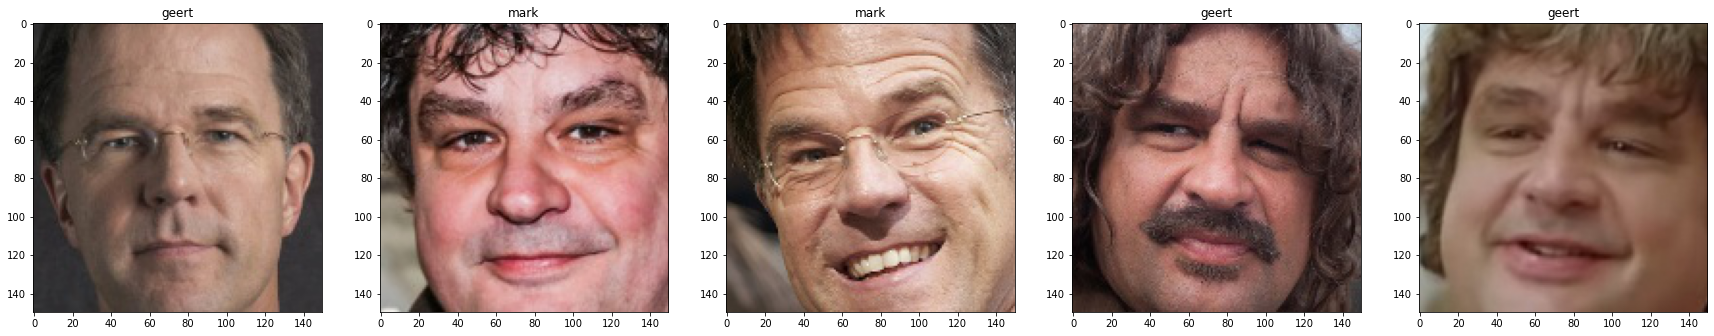

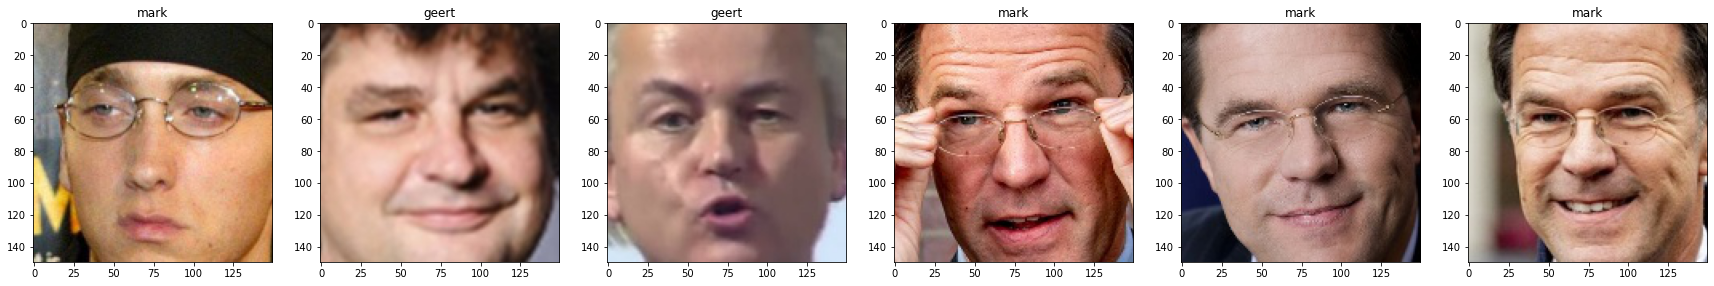

In [23]:
fig, ax = plt.subplots(1,5, figsize=(30, 12))
for i in range(0,5):
    ax[i].imshow(x[i])
    ax[i].set_title(tl[i])

fig, ax = plt.subplots(1,6, figsize=(30, 12))
for i in range(5,11):
    ax[i-10].imshow(x[i])
    ax[i-10].set_title(tl[i])


### De code hieronder laat zien hoe je een model kan opslaan en later weer gebruiken.

In [13]:
model.save('Frozen-cnn-100ep-100bat-size100-perfect-2.h5')

In [14]:
from keras.models import load_model

model = load_model('Frozen-cnn-100ep-100bat-size100-perfect-2.h5')

1/1 [==============================] - 1s 715ms/step - loss: 0.6934 - accuracy: 0.3636


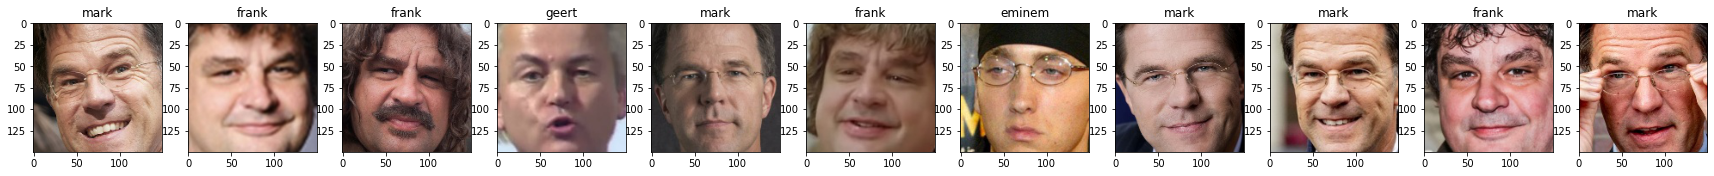

In [15]:
x , y = next(unknown_generator)
test_loss, test_acc = model.evaluate(x, y)

tl = [ names[np.argmax(res)] for res in y] 
fig, ax = plt.subplots(1,11, figsize=(30, 12))
for i in range(0,11):
    ax[i].imshow(x[i])
    ax[i].set_title(tl[i])

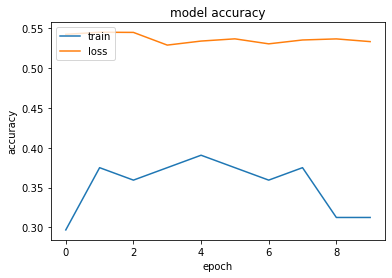

In [27]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()